# 模型选择、欠拟合和过拟合

通过多项式拟合来交互地探索这些概念

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

使用以下三阶多项式来生成训练和测试数据的标签：
$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2)$$

In [2]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

看一下前2个样本

In [4]:
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.4327],
         [-0.9153]]),
 tensor([[ 1.0000e+00, -4.3267e-01,  9.3602e-02, -1.3500e-02,  1.4602e-03,
          -1.2636e-04,  9.1119e-06, -5.6321e-07,  3.0461e-08, -1.4644e-09,
           6.3359e-11, -2.4922e-12,  8.9857e-14, -2.9906e-15,  9.2426e-17,
          -2.6660e-18,  7.2094e-20, -1.8349e-21,  4.4105e-23, -1.0044e-24],
         [ 1.0000e+00, -9.1529e-01,  4.1888e-01, -1.2780e-01,  2.9243e-02,
          -5.3532e-03,  8.1662e-04, -1.0678e-04,  1.2217e-05, -1.2424e-06,
           1.1372e-07, -9.4623e-09,  7.2173e-10, -5.0815e-11,  3.3222e-12,
          -2.0272e-13,  1.1597e-14, -6.2436e-16,  3.1749e-17, -1.5294e-18]]),
 tensor([3.8913, 1.7937]))

实现一个函数来评估模型在给定数据集上的损失

In [5]:
def evaluate_loss(net, data_iter, loss):  
    """评估给定数据集上模型的损失。"""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

定义训练函数

In [6]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(
                net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

三阶多项式函数拟合(正态)

weight: [[ 4.995938   1.1887105 -3.3931856  5.599084 ]]


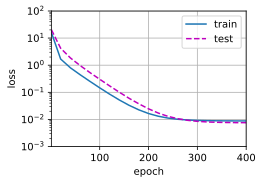

In [7]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

线性函数拟合(欠拟合)

weight: [[3.8673701 3.1964157]]


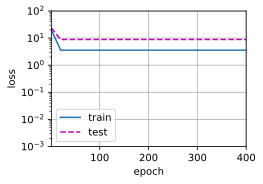

In [8]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

高阶多项式函数拟合(过拟合)

weight: [[ 4.9863100e+00  1.2614359e+00 -3.2860749e+00  5.2638183e+00
  -4.2739055e-01  1.0848706e+00  3.9890569e-02  2.1620892e-02
   1.2284118e-01  1.4214717e-01  9.2124246e-02  8.7570297e-03
  -1.6019754e-01 -2.0875530e-01  1.5320876e-01  1.3687256e-01
   2.2152846e-03 -9.3083180e-02 -2.1419232e-01  1.6589703e-01]]


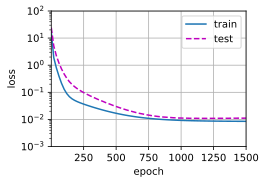

In [9]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)